In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import GridSearchCV

#### Loading Dataset

In [2]:
#Loading the datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#Summary statistics
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
#Checking for missing values in the training data
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
#Dataset Summary
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### Data Preprocessing

In [6]:
#Handling missing values for 'Age'
age_median_train = train_data['Age'].median()
train_data['Age'] = train_data['Age'].fillna(age_median_train)

age_median_test = test_data['Age'].median()
test_data['Age'] = test_data['Age'].fillna(age_median_test)

#Handling missing values for 'Embarked'
embarked_mode_train = train_data['Embarked'].mode()[0]
train_data['Embarked'] = train_data['Embarked'].fillna(embarked_mode_train)

embarked_mode_test = test_data['Embarked'].mode()[0]
test_data['Embarked'] = test_data['Embarked'].fillna(embarked_mode_test)

#Dropping 'Cabin'
train_data = train_data.drop('Cabin', axis=1)
test_data = test_data.drop('Cabin', axis=1)

In [7]:
#Encoding categorical data
train_data['Sex'] = train_data['Sex'].map({'male': 0, 'female': 1})
test_data['Sex'] = test_data['Sex'].map({'male': 0, 'female': 1})

train_data = pd.get_dummies(train_data, columns=['Embarked'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['Embarked'], drop_first=True)

In [8]:
#Combining Siblings/Spouse and Parents/Children feature as Family Size
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1

#Creating feature to check if passenger is alone
train_data['IsAlone'] = (train_data['FamilySize'] == 1).astype(int)
test_data['IsAlone'] = (test_data['FamilySize'] == 1).astype(int)

#Extracting titles from names
train_data['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_data['Title'] = test_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

#Simplifying titles, by grouping less common titles under a single 'Rare' category
common_titles = ['Mr', 'Miss', 'Mrs', 'Master']
train_data['Title'] = train_data['Title'].apply(lambda x: x if x in common_titles else 'Rare')
test_data['Title'] = test_data['Title'].apply(lambda x: x if x in common_titles else 'Rare')

#Encoding new 'Title' feature
title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
train_data['Title'] = train_data['Title'].map(title_mapping)
test_data['Title'] = test_data['Title'].map(title_mapping)

print(train_data.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    0  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.0      1      0   
2                             Heikkinen, Miss. Laina    1  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.0      1      0   
4                           Allen, Mr. William Henry    0  35.0      0      0   

             Ticket     Fare  Embarked_Q  Embarked_S  FamilySize  IsAlone  \
0         A/5 21171   7.2500       False        True           2        0   
1          PC 17599  71.2833       False       False           2        0   
2  STON/O2. 3101282   7.9250       False        True           1 

#### Exploratory Data Analysis

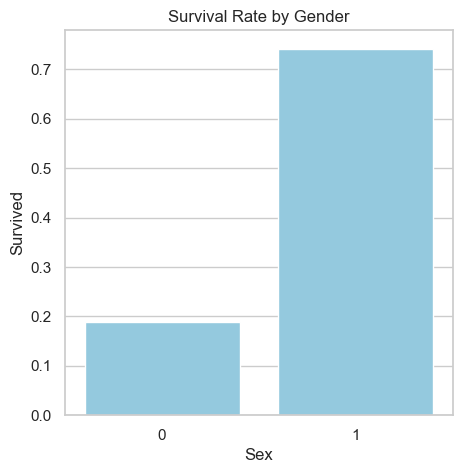

In [9]:
#Set style for seaborn
sns.set(style="whitegrid")

#Survival Rate by Gender
plt.figure(figsize=(5, 5))
sns.barplot(x='Sex', y='Survived', data=train_data, errorbar=None, color = 'skyblue', legend = False)
plt.title('Survival Rate by Gender')
plt.show()

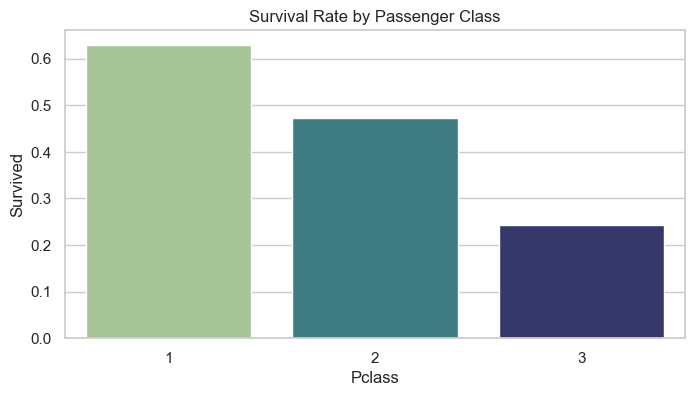

In [10]:
#Survival Rate by Passenger Class
plt.figure(figsize=(8, 4))
sns.barplot(x='Pclass', y='Survived',hue='Pclass', data=train_data, errorbar=None, palette = 'crest', legend=False)
plt.title('Survival Rate by Passenger Class')
plt.show()

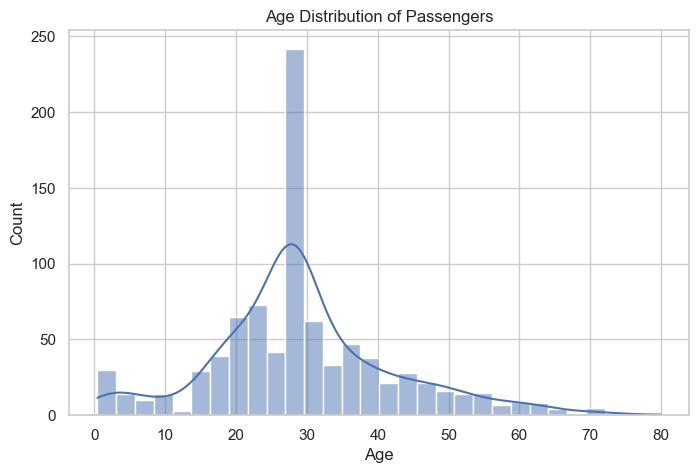

In [11]:
#Age Distribution of Passengers
plt.figure(figsize=(8, 5))
sns.histplot(train_data['Age'], kde=True, bins=30)
plt.title('Age Distribution of Passengers')
plt.show()

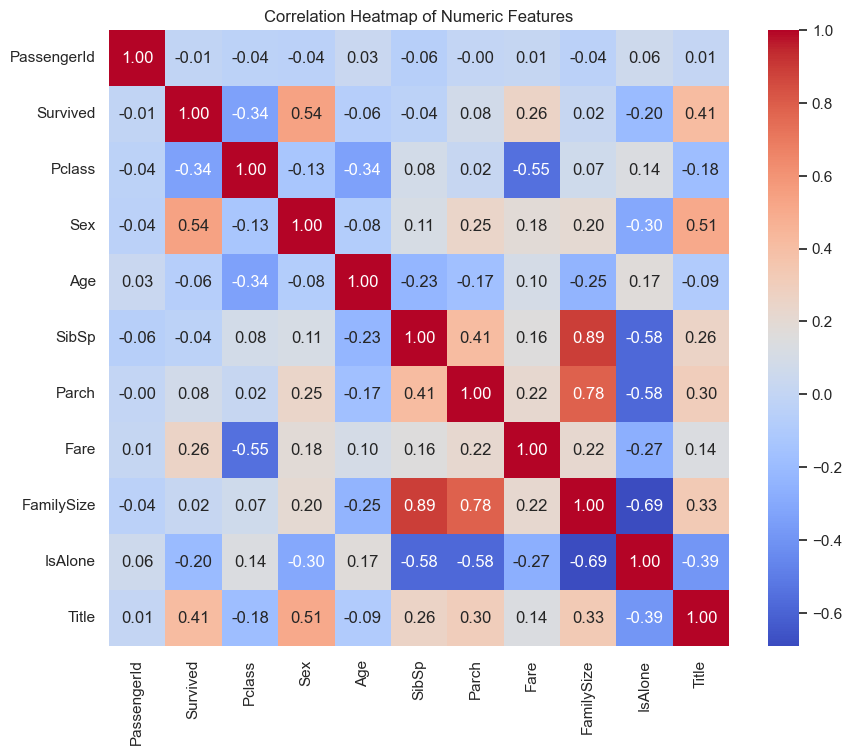

In [12]:
numeric_cols = train_data.select_dtypes(include=[np.number])  #Selecting only the numeric columns

#Computing the correlation matrix
corr_matrix = numeric_cols.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

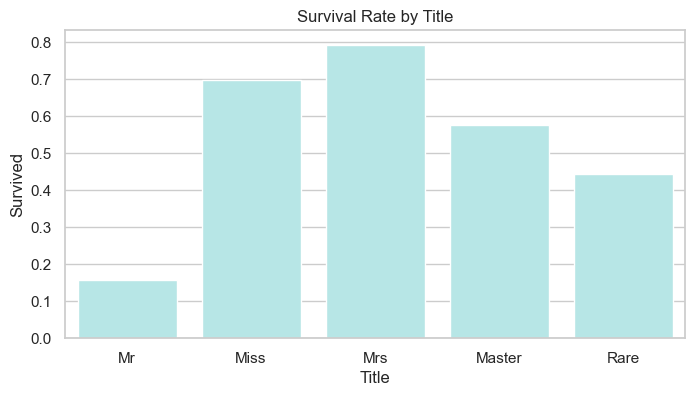

In [13]:
#Survival by Title
plt.figure(figsize=(8, 4))
sns.barplot(x='Title', y='Survived', data=train_data, errorbar = None, color = 'paleturquoise')
labels = ['Mr', 'Miss', 'Mrs', 'Master', 'Rare']
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=labels)  
plt.title('Survival Rate by Title')
plt.show()

#### Model Selection 

In [14]:
#Splitting data to create features and target
X = train_data.drop(['Survived','Name','Ticket'], axis=1)
y = train_data['Survived']

#Splitting data to separate out the test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Second split to separate out the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [15]:
#Training the model on the training data
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#Evaluating the model on the validation data
val_predictions = model.predict(X_val)
print(f"Validation Accuracy: {accuracy_score(y_val, val_predictions)}\n")
print(classification_report(y_val, val_predictions))

Validation Accuracy: 0.8258426966292135

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       112
           1       0.77      0.76      0.76        66

    accuracy                           0.83       178
   macro avg       0.81      0.81      0.81       178
weighted avg       0.83      0.83      0.83       178



#### Hyperparameter Tuning

In [16]:
#Initalizing parameter grid
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}

#Initializing the GridSearchCV object, using only training data for searching
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

#Evaluating the best model from grid search on the validation set
best_model = grid_search.best_estimator_
validation_predictions = best_model.predict(X_val)
print(f"Improved Validation Accuracy: {accuracy_score(y_val, validation_predictions)}")
print(classification_report(y_val, validation_predictions))

Improved Validation Accuracy: 0.8258426966292135
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       112
           1       0.77      0.76      0.76        66

    accuracy                           0.83       178
   macro avg       0.81      0.81      0.81       178
weighted avg       0.83      0.83      0.83       178



#### Final Evaluations

In [17]:
#Final evaluation on the test set
test_predictions = best_model.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, test_predictions)}")
print(classification_report(y_test, test_predictions))

Test Accuracy: 0.8547486033519553
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       105
           1       0.82      0.82      0.82        74

    accuracy                           0.85       179
   macro avg       0.85      0.85      0.85       179
weighted avg       0.85      0.85      0.85       179

